# Preliminary Classification Using Resampled Dataset
- Exactly the same code as the original nb06 except dataset with binned continuous variables is used.
- Use selection9 dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
if True:
    from imblearn.under_sampling import TomekLinks, RandomUnderSampler
    from imblearn.over_sampling import SMOTE, ADASYN

In [3]:
if True:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.svm import LinearSVC

In [4]:
selection9 = pd.read_csv('./data/select_train_data9.csv')
#selection10 = pd.read_csv('./data/select_train_data9.csv')
#selections = [selection9, selection10]

# Preprocess Majority

In [5]:
selection9.columns

Index(['ps_calc_05', 'ps_calc_07', 'ps_calc_13', 'ps_calc_14', 'ps_car_12',
       'ps_car_13', 'ps_ind_03', 'ps_ind_14', 'ps_reg_02', 'ps_reg_03',
       'ps_ind_07_bin', 'ps_ind_10_bin', 'ps_ind_12_bin', 'ps_ind_13_bin',
       'ps_ind_17_bin', 'ps_car_04_cat_5', 'ps_car_04_cat_7',
       'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8',
       'ps_car_11_cat_18', 'ps_car_11_cat_41', 'ps_ind_05_cat_2', 'target'],
      dtype='object')

In [6]:
X = np.array(selection9.iloc[:, :-1])
y = np.array(selection9.iloc[:, -1])

In [7]:
%%time
tl = TomekLinks(n_jobs=8, ratio='majority')
X_tl, y_tl = tl.fit_sample(X, y)

CPU times: user 5min 10s, sys: 151 ms, total: 5min 10s
Wall time: 1min 10s


In [8]:
print('Before tomek links: size of X: ', X.shape)
print('After  tomek links: size of X: ', X_tl.shape)

print('Before tomek links: class0/class1 = %d / %d' % (len(y)-np.sum(y), np.sum(y)))
print('After  tomek links: class0/class1 = %d / %d' % (len(y_tl)-np.sum(y_tl), np.sum(y_tl)))

Before tomek links: size of X:  (595212, 23)
After  tomek links: size of X:  (585439, 23)
Before tomek links: class0/class1 = 573518 / 21694
After  tomek links: class0/class1 = 563745 / 21694


# Undersampling class0 combined with oversampling of class1 by SMOTE

### Set up targets for number of samples for each class

In [9]:
num_class1 = np.sum(y_tl)
num_class1_to_resample = 3 * num_class1
num_class0_to_resample = int(1 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X_tl, y_tl)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

print('Before Resampling: size of X: ', X_tl.shape)
print('After  Resampling: size of X: ', X_tlrus.shape)

print('Before Resampling: class0/class1 =%7d/%6d' % (len(y_tl)-np.sum(y_tl), np.sum(y_tl)))
print('After  Resampling: class0/class1 =%7d/%6d' % (len(y_res)-np.sum(y_res), np.sum(y_res)))

Before Resampling: size of X:  (585439, 23)
After  Resampling: size of X:  (86776, 23)
Before Resampling: class0/class1 = 563745/ 21694
After  Resampling: class0/class1 =  65082/ 65082


### Run single round of classification with a set random_state for train_test split

======== Random Forest ========
             precision    recall  f1-score   support

          0     0.7300    0.8574    0.7886      6557
          1     0.8241    0.6782    0.7441      6460

avg / total     0.7767    0.7685    0.7665     13017

======== Gradient Boost ========
             precision    recall  f1-score   support

          0     0.7476    0.9837    0.8495      6557
          1     0.9756    0.6628    0.7894      6460

avg / total     0.8607    0.8245    0.8197     13017

======== Multinomial Naive Bayes ========
             precision    recall  f1-score   support

          0     0.5573    0.6006    0.5781      6557
          1     0.5599    0.5158    0.5369      6460

avg / total     0.5586    0.5585    0.5577     13017

======== LinearSVC ========
             precision    recall  f1-score   support

          0     0.5617    0.6320    0.5948      6557
          1     0.5721    0.4994    0.5333      6460

avg / total     0.5668    0.5662    0.5642     13017

CPU t

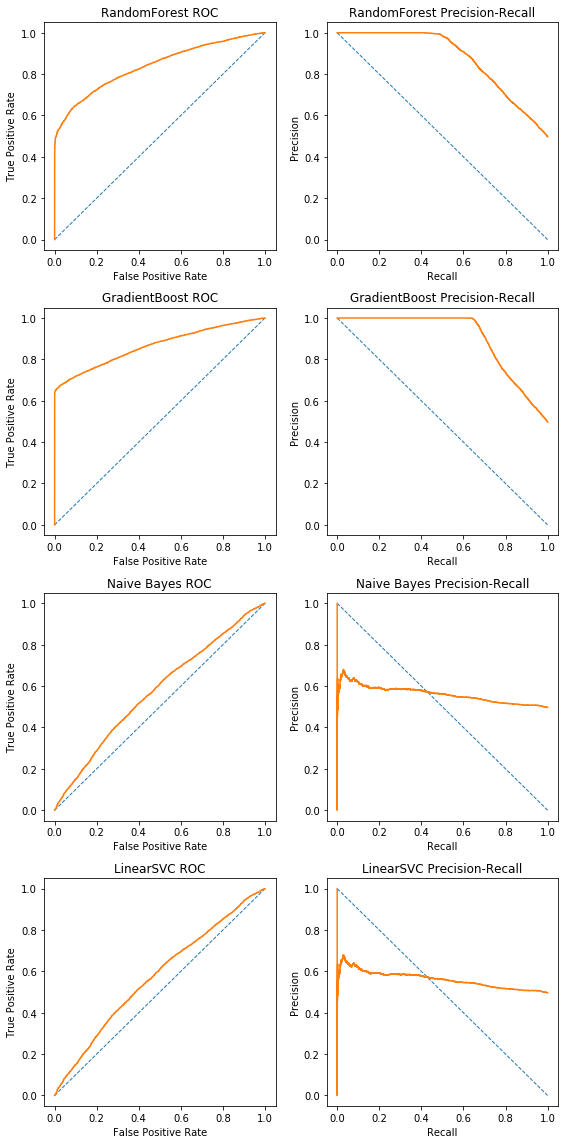

In [12]:
%%time
if True:
    
    rstate = 55
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.1, random_state=rstate)

    fig = plt.figure(figsize=(8, 16))
    neutral_line = np.linspace(0, 1, 10)

    # RandomForest
    rfc = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    rfc.fit(X_train, y_train)

    y_pred1 = rfc.predict(X_test)
    y_proba1 = rfc.predict_proba(X_test)
    report1 = classification_report(y_test, y_pred1, digits=4,
                                   labels=None, target_names=None)
    print('======== Random Forest ========')
    print(report1)

    precision1, recall1, _ = precision_recall_curve(y_test, y_proba1[:, 1], pos_label=1)
    fpr1, tpr1, _ = roc_curve(y_test, y_proba1[:, 1], pos_label=1)
    ax11 = fig.add_subplot(4, 2, 1)
    ax12 = fig.add_subplot(4, 2, 2)
    ax11.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax11.plot(fpr1, tpr1)
    ax11.set_xlabel('False Positive Rate')
    ax11.set_ylabel('True Positive Rate')
    ax11.set_title('RandomForest ROC')
    ax12.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
    ax12.plot(recall1, precision1)
    ax12.set_xlabel('Recall')
    ax12.set_ylabel('Precision')
    ax12.set_title('RandomForest Precision-Recall')

    # GradientBoost
    clf = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    clf.fit(X_train, y_train)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)
    print('======== Gradient Boost ========')
    print(report2)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21 = fig.add_subplot(4, 2, 3)
    ax22 = fig.add_subplot(4, 2, 4)
    ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

    # Naive Bayes
    nb = MultinomialNB()
    nb.fit(X_train, y_train)

    y_pred3 = nb.predict(X_test)
    y_proba3 = nb.predict_proba(X_test)
    report3 = classification_report(y_test, y_pred3, digits=4,
                                   labels=None, target_names=None)
    print('======== Multinomial Naive Bayes ========')
    print(report3)

    precision3, recall3, _ = precision_recall_curve(y_test, y_proba3[:, 1], pos_label=1)
    fpr3, tpr3, _ = roc_curve(y_test, y_proba3[:, 1], pos_label=1)
    ax31 = fig.add_subplot(4, 2, 5)
    ax32 = fig.add_subplot(4, 2, 6)
    ax31.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax31.plot(fpr3, tpr3)
    ax31.set_xlabel('False Positive Rate')
    ax31.set_ylabel('True Positive Rate')
    ax31.set_title('Naive Bayes ROC')
    ax32.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
    ax32.plot(recall3, precision3)
    ax32.set_xlabel('Recall')
    ax32.set_ylabel('Precision')
    ax32.set_title('Naive Bayes Precision-Recall')

    # Linear SVC
    scaler = StandardScaler()
    X_scaled =scaler.fit_transform(X_res)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled, y_res, test_size=0.1, random_state=rstate)

    svc = LinearSVC()
    svc.fit(X_train2, y_train2)

    y_pred4 = svc.predict(X_test2)
    y_score4 = svc.decision_function(X_test2)
    report4 = classification_report(y_test2, y_pred4, digits=4,
                                   labels=None, target_names=None)
    print('======== LinearSVC ========')
    print(report4)

    precision4, recall4, _ = precision_recall_curve(y_test, y_score4, pos_label=1)
    fpr4, tpr4, _ = roc_curve(y_test, y_score4, pos_label=1)
    ax41 = fig.add_subplot(4, 2, 7)
    ax42 = fig.add_subplot(4, 2, 8)
    ax41.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax41.plot(fpr3, tpr3)
    ax41.set_xlabel('False Positive Rate')
    ax41.set_ylabel('True Positive Rate')
    ax41.set_title('LinearSVC ROC')
    ax42.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
    ax42.plot(recall3, precision3)
    ax42.set_xlabel('Recall')
    ax42.set_ylabel('Precision')
    ax42.set_title('LinearSVC Precision-Recall')

    plt.tight_layout()

### Run classification multiple rounds with random train_test splitting (try 10 times)

CPU times: user 12min 2s, sys: 5.18 s, total: 12min 7s
Wall time: 5min 7s


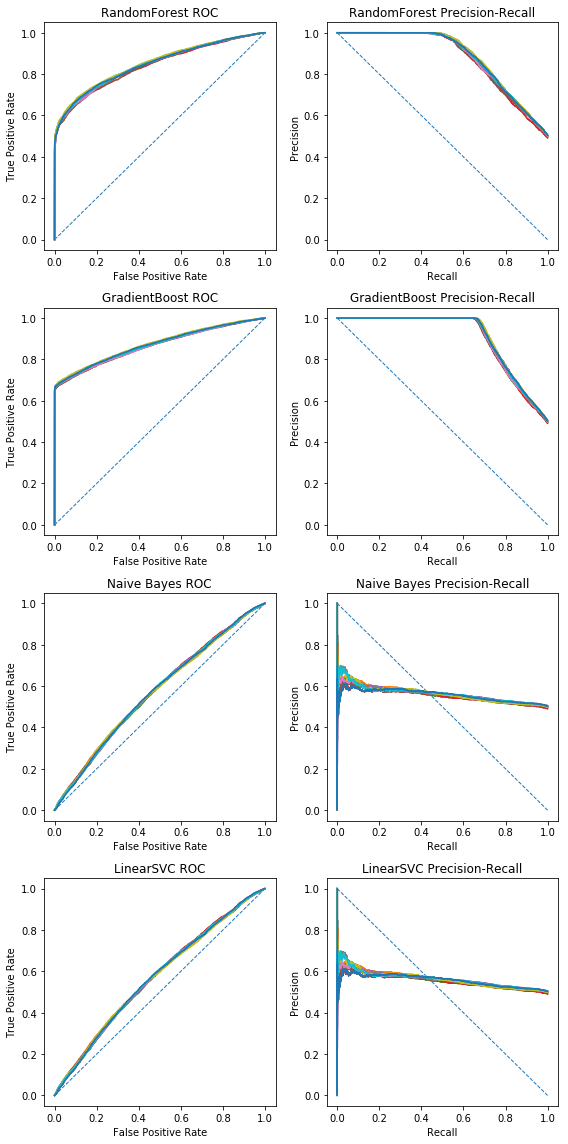

In [11]:
%%time
fig = plt.figure(figsize=(8, 16))
ax11 = fig.add_subplot(4, 2, 1)
ax12 = fig.add_subplot(4, 2, 2)
ax21 = fig.add_subplot(4, 2, 3)
ax22 = fig.add_subplot(4, 2, 4)
ax31 = fig.add_subplot(4, 2, 5)
ax32 = fig.add_subplot(4, 2, 6)
ax41 = fig.add_subplot(4, 2, 7)
ax42 = fig.add_subplot(4, 2, 8)

neutral_line = np.linspace(0, 1, 10)
ax11.plot(neutral_line, neutral_line, lw=1, ls='--')
ax12.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
ax31.plot(neutral_line, neutral_line, lw=1, ls='--')
ax32.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
ax41.plot(neutral_line, neutral_line, lw=1, ls='--')
ax42.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

for i in range(10):
    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.1, random_state=rstate)

    # RandomForest
    rfc = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    rfc.fit(X_train, y_train)

    y_pred1 = rfc.predict(X_test)
    y_proba1 = rfc.predict_proba(X_test)
    report1 = classification_report(y_test, y_pred1, digits=4,
                                   labels=None, target_names=None)

    precision1, recall1, _ = precision_recall_curve(y_test, y_proba1[:, 1], pos_label=1)
    fpr1, tpr1, _ = roc_curve(y_test, y_proba1[:, 1], pos_label=1)
    ax11.plot(fpr1, tpr1)
    ax11.set_xlabel('False Positive Rate')
    ax11.set_ylabel('True Positive Rate')
    ax11.set_title('RandomForest ROC')
    ax12.plot(recall1, precision1)
    ax12.set_xlabel('Recall')
    ax12.set_ylabel('Precision')
    ax12.set_title('RandomForest Precision-Recall')

    # GradientBoost
    clf = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    clf.fit(X_train, y_train)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

    # Naive Bayes
    nb = MultinomialNB()
    nb.fit(X_train, y_train)

    y_pred3 = nb.predict(X_test)
    y_proba3 = nb.predict_proba(X_test)
    report3 = classification_report(y_test, y_pred3, digits=4,
                                   labels=None, target_names=None)

    precision3, recall3, _ = precision_recall_curve(y_test, y_proba3[:, 1], pos_label=1)
    fpr3, tpr3, _ = roc_curve(y_test, y_proba3[:, 1], pos_label=1)
    ax31.plot(fpr3, tpr3)
    ax31.set_xlabel('False Positive Rate')
    ax31.set_ylabel('True Positive Rate')
    ax31.set_title('Naive Bayes ROC')
    ax32.plot(recall3, precision3)
    ax32.set_xlabel('Recall')
    ax32.set_ylabel('Precision')
    ax32.set_title('Naive Bayes Precision-Recall')

    # Linear SVC
    scaler = StandardScaler()
    X_scaled =scaler.fit_transform(X_res)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled, y_res, test_size=0.1, random_state=rstate)

    svc = LinearSVC()
    svc.fit(X_train2, y_train2)

    y_pred4 = svc.predict(X_test2)
    y_score4 = svc.decision_function(X_test2)
    report4 = classification_report(y_test2, y_pred4, digits=4,
                                   labels=None, target_names=None)

    precision4, recall4, _ = precision_recall_curve(y_test, y_score4, pos_label=1)
    fpr4, tpr4, _ = roc_curve(y_test, y_score4, pos_label=1)
    ax41.plot(fpr3, tpr3)
    ax41.set_xlabel('False Positive Rate')
    ax41.set_ylabel('True Positive Rate')
    ax41.set_title('LinearSVC ROC')
    ax42.plot(recall3, precision3)
    ax42.set_xlabel('Recall')
    ax42.set_ylabel('Precision')
    ax42.set_title('LinearSVC Precision-Recall')

plt.tight_layout()

- All the models are not really dependent on the train_test splits.
- RandomForest and GradientBoost appear most promising

## Conclusion
- Some improvement with RandomForest using binned continuous feature